In [ ]:
options(warn = -1)
library(dplyr)
library(repr)
library(Seurat)
library(reticulate)
library(data.table)
library(ggplot2)

In [ ]:
df <- read.table("/research/groups/bioinformaticians/internship/aalizade/Trainee/infercnv/40D_few_new/infercnv.observation_groupings.txt", header = TRUE, sep = " ", quote="\"", stringsAsFactors = FALSE)
library(Seurat)
a <- readRDS("/research/groups/bioinformaticians/internship/aalizade/Thesis/scRNA/singler/40D.rds")
sobj <- UpdateSeuratObject(object = a)
cells_to_find <- rownames(df)
df$singlr_labels <- sobj@meta.data[cells_to_find, "singlr_labels"]

In [4]:
df <- read.table("/research/groups/bioinformaticians/internship/aalizade/Trainee/infercnv/10x/42D_k5/HMM_CNV_predictions.HMMi6.leiden.hmm_mode-subclusters.Pnorm_0.5.pred_cnv_regions.dat", sep = "\t", header = TRUE)

In [ ]:
df_merged <- df %>%
  mutate(state = state - 1) %>%  # Subtract 1 from all state values
  filter(state != 2) %>%  # Remove rows where the new state == 2 (normal, original state == 3)
  group_by(state, chr, start, end) %>%
  summarise(cell_merge = paste(unique(cell_merge), collapse = ","), .groups = "drop")
dim(df_merged)

In [ ]:
# remove over-segmented regions by merging them
df <- as.data.table(df_merged)
df <- df[order(chr, start)]
df[, group := cumsum(c(1, diff(start) > 999999 | diff(end) > 999999)), by = .(state, chr)]
df_merged <- df[, .(
  start = min(start),  # Take the minimum start position in each group
  end = max(end),      # Take the maximum end position in each group
  cell_merge = paste(unique(cell_merge), collapse = ",")  # Merge cell names
), by = .(state, chr, group)]

df_merged[, group := NULL]
dim(df_merged)

In [ ]:
df_m <- df_m[, .(
  start = min(start),    # Keep the start value (it will be the same within a group)
  end = max(end),        # Keep the maximum end value in the group
  state = unique(state),  # Keep the state value
cell_merge = paste(unique(cell_merge), collapse = ",")
), by = .(chr, end, state)]
df_m[, end := NULL]
df_m[, state := NULL]


# Print the final result
dim(df_m)

In [9]:
# changes copy number states to 2 states of duplication and deletion for comparing simplicity 
df_m <- df_merged
df_m <- df_m %>%
  mutate(state = ifelse(state == 3, "DUP", state))
df_m <- df_m %>%
  mutate(state = ifelse(state == 4, "DUP", state))
df_m <- df_m %>%
  mutate(state = ifelse(state == 5, "DUP", state))
df_m <- df_m %>%
  mutate(state = ifelse(state == 1, "DEL", state))
df_m <- df_m %>%
  mutate(state = ifelse(state == 0, "DEL", state))
df_m <- df_m %>%
  mutate(state = ifelse(state == 2, "DEL", state))
table(df_m$state)

In [12]:
seg_data <- df_m
convert_to_bed <- function(seg_dat) {
  bed_data <- data.frame(
    chrom = seg_data$chr,
    start = seg_data$start - 1,
    end = seg_data$end,
    name = seg_data$cell_merge,
    score = seg_data$state
  )
  return(bed_data)
}
bed_data <- convert_to_bed(seg_data)
write.table(bed_data, file = "infercnv.bed", quote = FALSE, sep = "\t", row.names = FALSE, col.names = FALSE)

In [ ]:
%%bash
module load bedtools/2.30.0
a_dir="/research/groups/bioinformaticians/internship/aalizade/scenicplus1"
b_file="/research/groups/bioinformaticians/internship/aalizade/scenicplus1/blacklist/hg38-blacklist.v2.bed"
for a_file in "$a_dir"/*.bed; do
    output_file="${a_file%.bed}_blck.bed"
    bedtools intersect -a "$a_file" -b "$b_file" -f 0.50 -v > "$output_file"
    echo "Processed $a_file and saved as bed_new"
done

In [ ]:
%%bash
sort -k1,1V -k2,2n scevan.bed \
> sce.bed

%%bash
sort -k1,1V -k2,2n infercnv.bed \
> inf.bed

%%bash
module load bedtools/2.30.0
bedtools intersect -a /research/groups/bioinformaticians/internship/aalizade/Thesis/ASCAT/42_DNTR.bed -b sce.bed -f 0.50 -wo > recall_sce.bed

%%bash
module load bedtools/2.30.0
bedtools intersect -a sce.bed -b /research/groups/bioinformaticians/internship/aalizade/Thesis/ASCAT/42_DNTR.bed -F 0.50 -wo > precision_sce.bed

In [ ]:
wgs_infercnv_overlap <- read.table("wgs_infercnv_overlap.bed", header=FALSE, sep="\t")
wgs_scevan_overlap <- read.table("wgs_scevan_overlap.bed", header=FALSE, sep="\t")

colnames(wgs_infercnv_overlap) <- c("chr", "start", "end", "major", "minor", "WGS", "length", "chr_infercnv", "start_infercnv", "end_infercnv", "clone", "InferCNV")
colnames(wgs_scevan_overlap) <- c("chr", "start", "end", "major", "minor", "WGS", "length", "chr_scevan", "start_scevan", "end_scevan", "clone", "SCEVAN")
#wgs_scevan_overlap$WGS <- wgs_scevan_overlap$major + wgs_scevan_overlap$minor
#wgs_infercnv_overlap$WGS <- wgs_infercnv_overlap$major + wgs_infercnv_overlap$minor

matched_cnv <- merge(wgs_infercnv_overlap[, c("chr", "start", "end", "WGS", "InferCNV")], 
                      wgs_scevan_overlap[, c("chr", "start", "end", "SCEVAN")], 
                      by = c("chr", "start", "end"), all = TRUE)

In [ ]:
df <- matched_cnv
df$Agreement <- rowSums(df[, c("InferCNV", "SCEVAN")] == df$WGS)
df$Mismatch <- df$Agreement < 2  # TRUE if at least one method disagrees
head(df)

In [4]:
png(filename = "/research/groups/bioinformaticians/internship/aalizade/Thesis/cnvagree.png", width = 500, height = 500)

library(ggplot2)
ggplot(df, aes(x = as.factor(Agreement))) +
  geom_bar(fill = "blue") +
  labs(title = "CNV Agreement Between WGS, InferCNV, and SCEVAN",
       x = "Number of Matching Methods",
       y = "Count of Regions")
dev.off()

pdf 
  2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




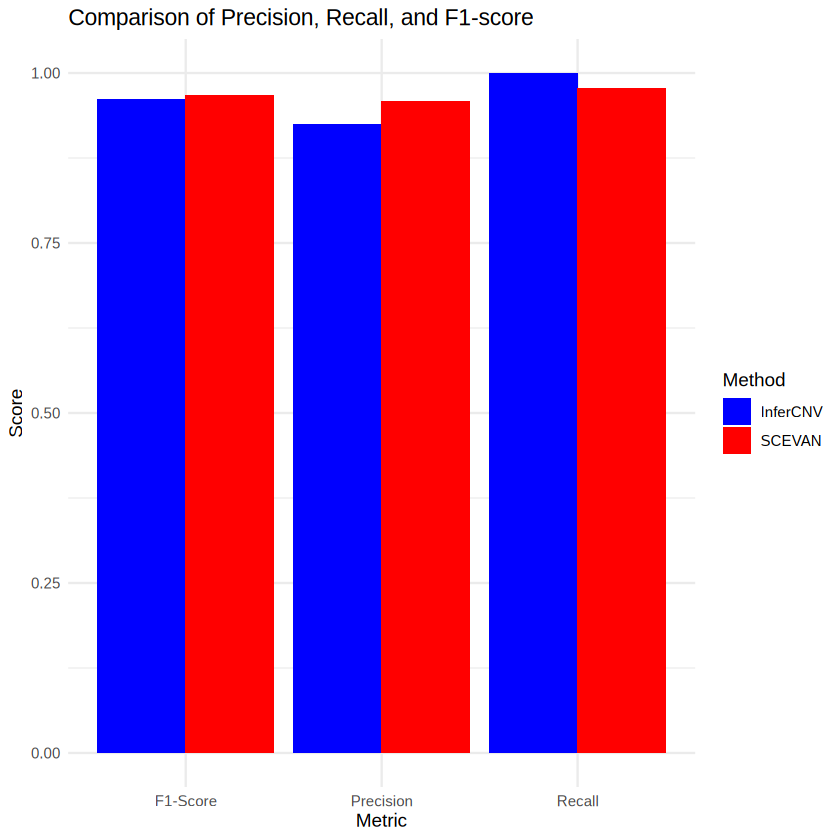

In [22]:
df_plot <- data.frame(
  Method = rep(c("InferCNV", "SCEVAN"), each = 3),
  Metric = rep(c("Precision", "Recall", "F1-Score"), times = 2),
  Value = c(InferCNV_Precision, InferCNV_Recall, InferCNV_F1, 
            SCEVAN_Precision, SCEVAN_Recall, SCEVAN_F1)
)
ggplot(df_plot, aes(x = Metric, y = Value, fill = Method)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_manual(values = c("blue", "red")) +
  labs(title = "Comparison of Precision, Recall, and F1-score",
       x = "Metric",
       y = "Score") +
  theme_minimal()

## inferCNV

In [1]:
library(dplyr)
df <- read.table("recall_inf.bed", sep = "\t", header = FALSE)
df_mutuals <- df %>%
  filter(V6 == V11) %>% 
  group_by(V6) %>%
  distinct(V1, V2, V3) %>%
  summarise(count = n())

print(df_mutuals)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# A tibble: 2 × 2
  V6    count
  <chr> <int>
1 DEL       5
2 DUP       3


In [2]:
df <- read.table("precision_inf.bed", sep = "\t", header = FALSE)
df_mutuals <- df %>%
  filter(V5 == V11) %>% 
  group_by(V5) %>%
  summarise(count = n())

print(df_mutuals)

# A tibble: 2 × 2
  V5    count
  <chr> <int>
1 DEL       7
2 DUP      17


In [3]:
a <- read.table("/research/groups/bioinformaticians/internship/aalizade/Thesis/ASCAT/42_DNTR.bed", sep ="\t", header = FALSE)
#library(dplyr)
#a <- a %>% filter(V6 == "DEL")
table(a$V6)


DEL DUP 
  7   3 

In [21]:
library(ggplot2)
png(filename = "cnvtype.png", width = 300, height = 300)

df2 <- data.frame(CNV_type=rep(c("Gain", "Loss", "LOH"), each=3),
                Sample=rep(c("40D", "42D", "47D"),3),
                Relative_abundance=c(0.29, 0.12, 0.42, 0.58, 0.88, 0.42, 0.12, 0.08, 0.16))
ggplot(data=df2, aes(x=Sample, y=Relative_abundance, fill=CNV_type)) +
  geom_bar(stat="identity") +
  scale_fill_manual(values = c("Gain" = "red", "Loss" = "blue", "LOH" = "green")) +
  theme_minimal()
dev.off()

pdf 
  2

# SCEVAN

In [4]:
library(dplyr)
dir_path <- "/research/groups/bioinformaticians/internship/aalizade/Thesis/SCEVAN_runs/42IG1clean/"
seg_files <- list.files(path = dir_path, pattern = ".*counts.*\\.seg$", full.names = TRUE)
df_list <- list()
for (file in seg_files) {
  df <- read.table(file, header = TRUE, sep = "\t")
  
  df <- df %>% filter(CN != 2)
  
  df$Chr <- paste0("chr", df$Chr)
  
  df$clone <- gsub("^.*/.*?_counts_|\\.seg$", "", file)
  
  df_list[[file]] <- df
}

merged_df <- bind_rows(df_list)
rownames(merged_df) <- NULL
dim(merged_df)

[1] 47  6

In [5]:
library(data.table)
df <- as.data.table(merged_df)
df <- df[order(Chr, Pos)]
df[, group := cumsum(c(1, diff(Pos) > 999999 | diff(End) > 999999)), by = .(CN, Chr)]
df_merged <- df[, .(
  start = min(Pos),  # Take the minimum start position in each group
  end = max(End),      # Take the maximum end position in each group
  clone = paste(unique(clone), collapse = ",")  # Merge cell names
), by = .(CN, Chr, group)]

df_merged[, group := NULL]

# Print result
dim(df_merged)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




[1] 36  5

In [6]:
df_m <- df_merged
df_m <- df_m %>%
  mutate(CN = ifelse(CN == 3, "DUP", CN))
df_m <- df_m %>%
  mutate(CN = ifelse(CN == 4, "DUP", CN))
df_m <- df_m %>%
  mutate(CN = ifelse(CN == 5, "DUP", CN))
df_m <- df_m %>%
  mutate(CN = ifelse(CN == 1, "DEL", CN))
df_m <- df_m %>%
  mutate(CN = ifelse(CN == 0, "DEL", CN))

In [7]:
table(df_m$CN)


DEL DUP 
  6  30 

In [8]:
seg_data <- df_m
convert_to_bed <- function(seg_dat) {
  bed_data <- data.frame(
    chrom = seg_data$Chr,
    start = seg_data$start - 1,
    end = seg_data$end,
    name = seg_data$clone,
    score = seg_data$CN
  )
  return(bed_data)
}
bed_data <- convert_to_bed(seg_data)
#bed_file <- file.path("", "research", "groups", "bioinformaticians", "internship", "aalizade", "scRNA_bed", "EG15.bed")
write.table(bed_data, file = "scevan.bed", quote = FALSE, sep = "\t", row.names = FALSE, col.names = FALSE)

## Numbat

In [ ]:
## example code for adding probabilities to the R object
nb = Numbat$new(out_dir = '/research/groups/bioinformaticians/internship/aalizade/Trainee/numbat/runs/40D_default')

df <- nb$joint_post

cell_data_21b <- df %>%
    filter(seg == "21b") %>%
    select(cell, p_cnv) %>%
    distinct() %>%
    rename(joint_21b = p_cnv)

merged <- df %>%
  left_join(cell_data_21b, by = "cell")

unique_cells_df <- merged %>% distinct(cell, .keep_all = TRUE)

joint_probabilities <- unique_cells_df[, c("cell", "joint_21b")]

rownames(joint_probabilities) <- joint_probabilities$cell
joint_probabilities$cell <- NULL 

seurat_obj <- AddMetaData(seurat_obj, metadata = joint_probabilities)
seurat_obj@meta.data[is.na(seurat_obj@meta.data)] <- 0

## correlation between tools

In [ ]:
merged_data <- inner_join(params, f1_scores, by = "sample")
cor_matrix <- cor(merged_data[,-1])
corrplot(cor_matrix, method = "color", tl.cex = 0.7, type = "upper", order = "hclust")

In [1]:
png(filename = "correlation.png", width = 1500, height = 900)
library(ggplot2)
library(reshape2)
library(dplyr)

char_data <- data.frame(
  Characteristics = c("num_cell", "num_malignant", "num_healthy_ref", "num_G1", 
                      "median_genes_per_cell", "GT_DUP_portion", "GT_DEL_portion", 
                      "log10(mean_CNV_size)", "log10(mean_DEL_size)", "log10(mean_DUP_size)", "DUP_log10size>6_portion", "DEL_log10size>6_portion"),
  `40D` = c(5562, 3926, 1636, 3686, 2200, 29.4, 58.8, 7.0546, 7.05, 7.13, 60, 50),
  `42D` = c(3515, 3203, 312, 2321, 1577, 11.1, 81.5, 6.2870, 6.28, 6.40, 66.6, 4.5),
  `47D` = c(2752, 2579, 173, 1625, 3264, 41.6, 41.6, 7.3674, 7.36, 7.44, 86.6, 6.6)
  #`DNTR40` = c(155, 53, 208, 357, 1928, 29.4, 58.8, 7.0546, 7.05, 7.13, 60, 50),
  #`DNTR42` = c(82, 11, 93, 250, 1785, 11.1, 81.5, 6.2870, 6.28, 6.40, 66.6, 4.5)
)

f1_data <- data.frame(
  Method = c("inferCNV_Gain", "inferCNV_Loss", "SCEVAN_Gain", "SCEVAN_Loss", "Numbat_Gain", "Numbat_Loss", "inferCNV", "SCEVAN", "Numbat"),
  `40D` = c(12.5, 17.7, 14.4, 33.8, 75, 57, 13.6, 23.2, 58.2),
  `42D` = c(12, 58.6, 0, 14.5, 39.8, 0, 37.4, 12.8, 6.8),
  `47D` = c(62, 15.6, 18.3, 7.8, 92.8, 0, 44.8, 13.1, 53)
   #`DNTR40` = c(16.5, 11.7, 12.6, 9.6, NA, NA),
  #`DNTR42` = c(24.4, 6.8, 24.4, 11.7, NA, NA)
)

char_long <- melt(char_data, id.vars = "Characteristics", variable.name = "Sample", value.name = "Value")
f1_long <- melt(f1_data, id.vars = "Method", variable.name = "Sample", value.name = "F1_Score")

merged_data <- inner_join(char_long, f1_long, by = "Sample")

cor_matrix <- merged_data %>%
  group_by(Method, Characteristics) %>%
  summarise(Correlation = cor(Value, F1_Score, method = "pearson")) %>%
  ungroup()

ggplot(cor_matrix, aes(x = Method, y = Characteristics, fill = Correlation)) +
  geom_tile(color = "white") +
  geom_text(aes(label = round(Correlation, 2)), color = "black", size = 7) +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  theme_minimal() +
  labs(title = "Correlation Heatmap: Characteristics vs Methods", 
       x = "Method", y = "Characteristics", fill = "Correlation") +
  theme(
    plot.title = element_text(size = 24, face = "bold"), 
    axis.text.x = element_text(size = 18, angle = 45, hjust = 1), 
    axis.text.y = element_text(size = 18), 
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20), 
    legend.title = element_text(size = 18), 
    legend.text = element_text(size = 16)
  )
dev.off()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in inner_join(char_long, f1_long, by = "Sample"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”
`summarise()` has grouped output by 'Method'. You can override using the `.groups` argument.


pdf 
  2

### Correlation between each pair of tools

In [109]:
png(filename = "correlation.png", width = 600, height = 500)
ggplot(cor_results, aes(x = cor_expr1_expr2, y = cor_expr1_expr3, color = cor_expr2_expr3)) +
  geom_point(alpha = 0.6, size = 2) +
  scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  theme_minimal() +
  labs(title = "Pairwise Correlation Scatter Plot",
       x = "Correlation (SCEVAN vs inferCNV)",
       y = "Correlation (SCEVAN vs Numbat)",
       color = "inferCNV vs Numbat") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black")
dev.off()

pdf 
  2

In [114]:
png(filename = "correlation.png", width = 400, height = 400)
library(ggplot2)
ggplot(cor_results, aes(x = names(cor12), y = cor_expr2_expr3)) +
  geom_point(color = "blue", alpha = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") + 
  theme_minimal() +
  labs(title = "Correlation of Mean Expression per Region per Cell",
       x = "Cell Barcode",
       y = "Pearson Correlation") +
  theme(axis.text.x = element_blank(), 
        axis.ticks.x = element_blank())
dev.off()

pdf 
  2

In [2]:
png("heatmp.png", width = 500, height = 500)
library(ggplot2)
library(reshape2)
data <- data.frame(
  Sample = c("ALL340D", "ALL342D", "ALL347D"),
  inferCNV_Precision = c(7.6, 25.5, 52.7),
  inferCNV_Recall = c(64.7, 70.3, 39),
  inferCNV_F1 = c(13.6, 37.4, 44.8),
  SCEVAN_Precision = c(19.2, 15.1, 8.4),
  SCEVAN_Recall = c(29.4, 11.1, 30.5),
  SCEVAN_F1 = c(23.2, 12.8, 13.1),
  Numbat_Precision = c(100, 50, 100),
  Numbat_Recall = c(41.1, 3.7, 36.1),
  Numbat_F1 = c(58.2, 6.8, 53)
)

data_long <- melt(data, id.vars = "Sample")
colnames(data_long) <- c("Sample", "Metric", "Value")

ggplot(data_long, aes(x = Metric, y = Sample, fill = Value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 50) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Heatmap of Precision, Recall, and F1 Scores",
       fill = "Value")
dev.off()

pdf 
  2